In [108]:
pip install google-generativeai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/student/.virtualenvs/final-project/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [109]:
"""
RAG from Pinecone + Gemini (single question OR batch from Q&A ZIP)

What this script does:
- Embeds an input question with SentenceTransformers.
- Queries a Pinecone index to get top-k nearest chunks 
- Sends the question + the 3 retrieved chunks to Gemini with strict instructions.
- Prints Gemini's answer.
- (Optional) Batch mode: iterate JSONL files under Q&A/ inside a ZIP; for each
  question do the same retrieval+answer. If a letter exists, print summary
  of correct/total for each file. The answer is NEVER sent to the model.

Assumptions about Pinecone vectors:
- Each vector has metadata with a "text" field that holds the chunk content
  (e.g., first 1000 chars as אצלך), plus optional "file"/"chunk_id".

Replace API keys or pass via CLI flags.
"""
# ================================
# Standard library
# ================================
import os
import time
import re
import io
import json
import argparse
from typing import List, Dict, Any, Optional, Tuple
from pathlib import Path
from zipfile import ZipFile
import torch

# ================================
# Numerics & progress
# ================================
import numpy as np              
from tqdm import tqdm      

# ================================
# Embeddings
# ================================
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize 

# ================================
# Vector database (Pinecone)
# ================================
from pinecone import Pinecone

# ================================
# LLM client
# ================================
from openai import AzureOpenAI

# -----------------------------
# Defaults / Config
# -----------------------------
DEFAULT_EMB_MODEL = "multi-qa-mpnet-base-dot-v1"

In [110]:
# ------------ Azure OpenAI ------------
def configure_azure_openai(endpoint: str, api_key: str, api_version: str) -> AzureOpenAI:
    """Create Azure OpenAI client."""
    return AzureOpenAI(azure_endpoint=endpoint, api_key=api_key, api_version=api_version)

def ask_azure_chat(client: AzureOpenAI, deployment: str, system_prompt: str, user_prompt: str) -> str:
    """Call Azure OpenAI Chat Completions (temperature=0) and return text."""
    resp = client.chat.completions.create(
        model=deployment,
        messages=[{"role": "system", "content": system_prompt}, {"role": "user", "content": user_prompt}],
        temperature=0,
    )
    return (resp.choices[0].message.content or "").strip()

In [111]:
# ------------ Embeddings & Pinecone ------------
DEFAULT_EMB_MODEL = "multi-qa-mpnet-base-dot-v1"

def load_embedder(model_name: str = DEFAULT_EMB_MODEL) -> SentenceTransformer:
    print(f"🔹 Loading embedding model '{model_name}' ...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    return SentenceTransformer(model_name, device=device)

def embed_query(text: str, emb_model: SentenceTransformer) -> np.ndarray:
    vec = emb_model.encode([text], convert_to_numpy=True)
    return normalize(vec, axis=1).astype("float32")[0]


def query_pinecone(
    pc: Pinecone,
    index_name: str,
    namespace: str,
    query_vec: np.ndarray,
    top_k: int = 3,
    include_metadata: bool = True
) -> List[Dict[str, Any]]:
    index = pc.Index(index_name)
    #norm = np.linalg.norm(query_vec)
    #if norm > 0:
        #query_vec = query_vec / norm

    res = index.query(
        vector=query_vec.tolist(),
        top_k=top_k,
        include_metadata=include_metadata,
        namespace=namespace
    )
    matches = []
    for m in getattr(res, "matches", []) or []:
        matches.append({
            "id": m.get("id") if isinstance(m, dict) else getattr(m, "id", None),
            "score": m.get("score") if isinstance(m, dict) else getattr(m, "score", None),
            "metadata": m.get("metadata") if isinstance(m, dict) else getattr(m, "metadata", None),
        })
    return matches

In [112]:
# ------------ Q&A parsing ------------
ANSWER_KEYS = ["correct_answer"]

def parse_options_to_block(options: Any) -> Tuple[str, Dict[str, str]]:
    """Normalize options into printable block + map letter->text."""
    letter_map: Dict[str, str] = {}
    if isinstance(options, dict):
        keys = list(options.keys())
        if all(k.upper() in list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") for k in keys):
            ordered = sorted(keys, key=lambda x: list("ABCDEFGHIJKLMNOPQRSTUVWXYZ").index(x.upper()))
        else:
            ordered = sorted(keys)
        for i, k in enumerate(ordered):
            letter_map[chr(ord('A') + i)] = str(options[k])
    elif isinstance(options, list):
        for i, opt in enumerate(options):
            letter_map[chr(ord('A') + i)] = str(opt)
    else:
        letter_map["A"] = str(options)
    block = "\n".join([f"{k}) {v}" for k, v in letter_map.items()])
    return block, letter_map

def extract_correct_letter(obj: Dict[str, Any]) -> Optional[str]:
    for k in ANSWER_KEYS:
        if k in obj and obj[k] not in (None, ""):
            val = str(obj[k]).strip()
            if len(val) == 1 and val.upper() in list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
                return val.upper()
            return None
    return None

def parse_qa_line(line: str) -> Optional[Dict[str, Any]]:
    try:
        obj = json.loads(line)
    except Exception:
        return None
    q = str(obj.get("question") or obj.get("query") or obj.get("prompt") or "").strip()
    if not q:
        return None
    options = obj.get("options") or obj.get("choices") or obj.get("answers") or None
    if options is None:
        letter_fields = [k for k in obj.keys() if len(k) == 1 and k.upper() in list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")]
        if letter_fields:
            options = {lf: obj[lf] for lf in letter_fields}
        else:
            return None
    options_block, letter_map = parse_options_to_block(options)
    correct_letter = extract_correct_letter(obj)
    return {
        "question_text": q,
        "options_block": options_block,
        "letter_map": letter_map,
        "correct_letter": correct_letter
    }

In [113]:
# ------------ Prompt ------------
def build_prompt_mcq(question_text: str, options_block: str, top_chunks: List[str]) -> tuple[str, str]:
    system_prompt = (
         "You are an academic RAG assistant.\n\n"
        "You will receive:\n"
        "- A multiple-choice question (MCQ) about study material.\n"
        "- Exactly three context chunks retrieved for this question.\n"
        "Instructions:\n"
        "1. Carefully read the question and the three chunks.\n"
        "2. Extract relevant information from the chunks.\n"
        "3. Combine this with your own external knowledge if needed (don’t limit yourself only to the chunks).\n"
        "4. Select the best answer option (A/B/C/D).\n"
        "5. Return a short final answer in the form: \"X\" (where X is the chosen letter).\n"
    )
    ctx = "\n\n".join([f"[Chunk {i+1}]\n{c}" for i, c in enumerate(top_chunks)])
    user_prompt = (
        f"Question:\n{question_text}\n\n"
        f"Options:\n{options_block}\n\n"
        f"Context:\n{ctx}\n\n"
        "Now, provide the best answer to the MCQ following the rules above."
    )
    return system_prompt, user_prompt

In [114]:
def run_batch_zip(
    pc: Pinecone,
    index_name: str,
    namespace: str,
    emb_model: SentenceTransformer,
    azure_client: AzureOpenAI,
    azure_deployment: str,
    qa_zip_path: Path,
    top_k: int = 3
) -> dict:
    """
    Iterate Q&A/*.jsonl in ZIP; for each question retrieve+answer;
    summarize accuracy if gold exists.
    Returns:
        results: dict
            {
              "filename.jsonl": {
                  "correct": int,
                  "total": int,
                  "accuracy": float,
                  "questions": [
                      {
                          "q_text": str,
                          "gold": str,
                          "pred": str,
                          "cosine_scores": [float,...]
                      },
                      ...
                  ]
              },
              ...
            }
    """
    from zipfile import ZipFile
    from tqdm import tqdm
    import re

    results = {}

    print(f"[run_batch_zip] ZIP path: {qa_zip_path}")
    if not qa_zip_path.exists():
        print("❌ ZIP not found. Exiting.")
        return results

    with ZipFile(qa_zip_path, "r") as zf:
        qa_files = [n for n in zf.namelist() if n.startswith("Q&A/") and n.lower().endswith(".jsonl")]
        print(f"[run_batch_zip] Q&A jsonl files found: {len(qa_files)}")

        for fname in qa_files:
            print(f"\n===== Processing: {fname} =====")
            raw = zf.read(fname).decode("utf-8", errors="ignore")
            lines = [ln for ln in raw.splitlines() if ln.strip()]

            total, correct = 0, 0
            question_results = []

            for i, line in enumerate(tqdm(lines, desc=f"Questions in {Path(fname).name}"), start=1):
                parsed = parse_qa_line(line)
                if not parsed:
                    continue

                q_text = parsed["question_text"]
                options_block = parsed["options_block"]
                gold = parsed["correct_letter"]

                # === Retrieval ===
                q_vec = embed_query(q_text, emb_model)
                matches = query_pinecone(pc, index_name, namespace, q_vec, top_k=top_k, include_metadata=True)

                if not matches:
                    total += 1
                    continue

                # Save similarity scores
                cosine_scores = [m.get("score") for m in matches]

                # === Prompt ===
                chunk_texts = [((m.get("metadata") or {}).get("text") or "").strip()
                               for m in matches[:top_k]]
                system_prompt, user_prompt = build_prompt_mcq(q_text, options_block, chunk_texts)

                try:
                    resp = ask_azure_chat(azure_client, azure_deployment, system_prompt, user_prompt)
                except Exception:
                    total += 1
                    continue

                head = (resp or "").strip().splitlines()[0] if resp else ""
                m = re.search(r"\b([A-F])\b", head.upper())
                pred = m.group(1) if m else None

                total += 1
                if gold and pred and pred.upper() == gold.upper():
                    correct += 1

                question_results.append({
                    "q_text": q_text,
                    "gold": gold,
                    "pred": pred,
                    "cosine_scores": cosine_scores
                })

            acc = (correct / total * 100.0) if total else 0.0
            results[Path(fname).name] = {
                "correct": correct,
                "total": total,
                "accuracy": acc,
                "questions": question_results
            }

            print(f"Summary for {fname}: {correct}/{total} correct ({acc:.2f}%)")

    return results


In [115]:
def list_namespaces(pc, index_name: str):
    """Return all non-empty namespaces in a Pinecone index."""
    idx = pc.Index(index_name)
    stats = idx.describe_index_stats()
    ns_map = stats.get("namespaces", {}) or {}
    namespaces = [ns for ns, meta in ns_map.items() if (meta or {}).get("vector_count", 0) > 0]
    return sorted(namespaces)

In [116]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [117]:
import matplotlib.pyplot as plt
import pandas as pd

def analysis_results(all_results: dict, baseline_json: str = "baseline_results.json", return_dfs: bool = False):
    import json
    import re
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt

    # --- helper: normalize course/file names to a common key ---
    def norm(name: str) -> str:
        stem = Path(name).stem  # drop extension if present
        stem = re.sub(r"\s+", " ", stem).strip().lower()  # collapse spaces, lowercase
        return stem

    # ---- Load baseline and normalize keys ----
    with open(baseline_json) as f:
        baseline_results = json.load(f)

    baseline_correct = {norm(fname): res["correct"] for fname, res in baseline_results.items()}

    print("\n🔍 Debug: Baseline (normalized) map")
    for k, v in sorted(baseline_correct.items()):
        print(f"  {k} -> {v}")

    # ---- Build DataFrames ----
    records_acc = []
    records_sim = []

    missing_in_baseline = set()

    for ns, ns_data in all_results.items():
        for fname, file_data in ns_data.items():
            course_key = norm(fname)
            base_val = baseline_correct.get(course_key)
            if base_val is None:
                missing_in_baseline.add(course_key)
                base_val = 0

            ours = file_data.get("correct", 0)
            total = file_data.get("total", 0)
            delta = ours - base_val if total > 0 else 0

            # debug per-course
            print(f"\n[Namespace={ns}] Course='{fname}' (norm='{course_key}')")
            print(f"  Our correct={ours}, Baseline={base_val}, Δ={delta}")

            if total > 0:
                records_acc.append({
                    "namespace": ns,
                    "course": fname,
                    "delta_correct": delta
                })

            for q in file_data.get("questions", []):
                for score in (q.get("cosine_scores") or []):
                    records_sim.append({
                        "namespace": ns,
                        "course": fname,
                        "similarity": score
                    })

    if missing_in_baseline:
        print("\n⚠️ Courses missing in baseline (after normalization):")
        for k in sorted(missing_in_baseline):
            print("  -", k)

    df_acc = pd.DataFrame(records_acc)
    df_sim = pd.DataFrame(records_sim)

    print("\n✅ First rows of accuracy DataFrame:")
    print(df_acc.head())
    print("\n✅ First rows of similarity DataFrame:")
    print(df_sim.head())

    # ---- Plot 1: Boxplot of Δcorrect answers per namespace ----
    plt.figure(figsize=(10,6))
    if not df_acc.empty:
        df_acc.boxplot(column="delta_correct", by="namespace")
        plt.title("Difference vs Baseline: Δ Correct Answers per Namespace")
        plt.suptitle("")
        plt.xlabel("Namespace")
        plt.ylabel("#Correct (RAG - Baseline)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ df_acc is empty; skipping accuracy boxplot.")

    # ---- Plot 2: Boxplot of cosine similarity ----
    plt.figure(figsize=(10,6))
    if not df_sim.empty:
        df_sim.boxplot(column="similarity", by="namespace")
        plt.title("Distribution of Query–Chunk Dot Product Scores")
        plt.suptitle("")
        plt.xlabel("Namespace")
        plt.ylabel("Dot product")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ df_sim is empty; skipping similarity boxplot.")

    # ---- Plot 3: Line plot of Δcorrect answers per course by namespace ----
    if not df_acc.empty:
        plt.figure(figsize=(14,6))

        # Pivot: rows=courses, cols=namespaces, values=delta_correct
        df_pivot = df_acc.pivot(index="course", columns="namespace", values="delta_correct")

        # Sort courses alphabetically (או לפי סדר שאתה רוצה)
        df_pivot = df_pivot.sort_index()

        # Plot each namespace as a line
        df_pivot.plot(marker="o", linewidth=2, alpha=0.7)

        plt.title("Relative Performance vs Baseline per Course")
        plt.xlabel("Course")
        plt.ylabel("Δ #Correct (RAG - Baseline)")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend(title="Namespace")
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ df_acc is empty; skipping per-course line plot.")

    # save dfs to json
    df_acc.to_json("df_accuracy.json", orient="records", indent=2)
    df_sim.to_json("df_similarity.json", orient="records", indent=2)

    return (df_acc, df_sim) if return_dfs else None

In [118]:
import json
import time
from pathlib import Path

# --- Constants ---
INDICES = ["dotproduct-300", "dotproduct-500", "dotproduct-700"]
TOP_K = 3
QA_ZIP = "Q&A.zip"
API_KEYS_PATH = "src/api_keys.json"

# --- Load API keys ---
with open(API_KEYS_PATH) as f:
    api_keys = json.load(f)
params = ['endpoint', 'deployment', 'subscription_key', 'api_version', 'pinecone']
for p in params:
    if p not in api_keys:
        raise ValueError(f"Missing '{p}' in api_keys.json")
azure_endpoint = api_keys["endpoint"]
azure_deployment = api_keys["deployment"]
azure_subscription_key = api_keys["subscription_key"]
azure_api_version = api_keys["api_version"]
pinecone_api_key = api_keys["pinecone"]

qa_zip_path = Path(QA_ZIP)
if not qa_zip_path.exists():
    raise FileNotFoundError(f"Q&A ZIP not found: {qa_zip_path}")


🔹 Initializing Pinecone client ...
🔹 Loading embedding model 'multi-qa-mpnet-base-dot-v1' ...
Using device: cuda

=== Evaluating index: dotproduct-300 ===
Found 3 namespaces: ['overlapping', 'recursive', 'spacy']

🚀 Running evaluation for namespace: overlapping
[run_batch_zip] ZIP path: Q&A.zip
[run_batch_zip] Q&A jsonl files found: 7

===== Processing: Q&A/Q&A/Algebraic Methods.jsonl =====


Questions in Algebraic Methods.jsonl: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


Summary for Q&A/Q&A/Algebraic Methods.jsonl: 22/30 correct (73.33%)

===== Processing: Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl =====


Questions in Algorithms in Uncertain Scenarios.jsonl: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


Summary for Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl: 25/30 correct (83.33%)

===== Processing: Q&A/Q&A/CausalInference.jsonl =====


Questions in CausalInference.jsonl: 100%|██████████| 30/30 [01:00<00:00,  2.00s/it]


Summary for Q&A/Q&A/CausalInference.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Electronic Commerce.jsonl =====


Questions in Electronic Commerce.jsonl: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


Summary for Q&A/Q&A/Electronic Commerce.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Information Retrieval.jsonl =====


Questions in Information Retrieval.jsonl: 100%|██████████| 30/30 [01:01<00:00,  2.06s/it]


Summary for Q&A/Q&A/Information Retrieval.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Introduction to AI.jsonl =====


Questions in Introduction to AI.jsonl: 100%|██████████| 29/29 [00:59<00:00,  2.04s/it]


Summary for Q&A/Q&A/Introduction to AI.jsonl: 27/29 correct (93.10%)

===== Processing: Q&A/Q&A/Software Engineering.jsonl =====


Questions in Software Engineering.jsonl: 100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


Summary for Q&A/Q&A/Software Engineering.jsonl: 30/30 correct (100.00%)

🚀 Running evaluation for namespace: recursive
[run_batch_zip] ZIP path: Q&A.zip
[run_batch_zip] Q&A jsonl files found: 7

===== Processing: Q&A/Q&A/Algebraic Methods.jsonl =====


Questions in Algebraic Methods.jsonl: 100%|██████████| 30/30 [00:09<00:00,  3.21it/s]


Summary for Q&A/Q&A/Algebraic Methods.jsonl: 23/30 correct (76.67%)

===== Processing: Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl =====


Questions in Algorithms in Uncertain Scenarios.jsonl: 100%|██████████| 30/30 [00:54<00:00,  1.83s/it]


Summary for Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl: 25/30 correct (83.33%)

===== Processing: Q&A/Q&A/CausalInference.jsonl =====


Questions in CausalInference.jsonl: 100%|██████████| 30/30 [00:48<00:00,  1.61s/it]


Summary for Q&A/Q&A/CausalInference.jsonl: 25/30 correct (83.33%)

===== Processing: Q&A/Q&A/Electronic Commerce.jsonl =====


Questions in Electronic Commerce.jsonl: 100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


Summary for Q&A/Q&A/Electronic Commerce.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Information Retrieval.jsonl =====


Questions in Information Retrieval.jsonl: 100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


Summary for Q&A/Q&A/Information Retrieval.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/Introduction to AI.jsonl =====


Questions in Introduction to AI.jsonl: 100%|██████████| 29/29 [00:15<00:00,  1.93it/s]


Summary for Q&A/Q&A/Introduction to AI.jsonl: 27/29 correct (93.10%)

===== Processing: Q&A/Q&A/Software Engineering.jsonl =====


Questions in Software Engineering.jsonl: 100%|██████████| 30/30 [00:53<00:00,  1.79s/it]


Summary for Q&A/Q&A/Software Engineering.jsonl: 30/30 correct (100.00%)

🚀 Running evaluation for namespace: spacy
[run_batch_zip] ZIP path: Q&A.zip
[run_batch_zip] Q&A jsonl files found: 7

===== Processing: Q&A/Q&A/Algebraic Methods.jsonl =====


Questions in Algebraic Methods.jsonl: 100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


Summary for Q&A/Q&A/Algebraic Methods.jsonl: 23/30 correct (76.67%)

===== Processing: Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl =====


Questions in Algorithms in Uncertain Scenarios.jsonl: 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


Summary for Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl: 25/30 correct (83.33%)

===== Processing: Q&A/Q&A/CausalInference.jsonl =====


Questions in CausalInference.jsonl: 100%|██████████| 30/30 [00:44<00:00,  1.47s/it]


Summary for Q&A/Q&A/CausalInference.jsonl: 25/30 correct (83.33%)

===== Processing: Q&A/Q&A/Electronic Commerce.jsonl =====


Questions in Electronic Commerce.jsonl: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


Summary for Q&A/Q&A/Electronic Commerce.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/Information Retrieval.jsonl =====


Questions in Information Retrieval.jsonl: 100%|██████████| 30/30 [00:48<00:00,  1.60s/it]


Summary for Q&A/Q&A/Information Retrieval.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Introduction to AI.jsonl =====


Questions in Introduction to AI.jsonl: 100%|██████████| 29/29 [00:47<00:00,  1.63s/it]


Summary for Q&A/Q&A/Introduction to AI.jsonl: 27/29 correct (93.10%)

===== Processing: Q&A/Q&A/Software Engineering.jsonl =====


Questions in Software Engineering.jsonl: 100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


Summary for Q&A/Q&A/Software Engineering.jsonl: 30/30 correct (100.00%)

--- Analysis for index: dotproduct-300 ---

🔍 Debug: Baseline (normalized) map
  algebraic methods -> 24
  algorithms in uncertain scenarios -> 20
  causalinference -> 26
  electronic commerc -> 27
  electronic commerce -> 27
  information retrieval -> 27
  introduction to ai -> 27
  software engineering -> 30

[Namespace=overlapping] Course='Algebraic Methods.jsonl' (norm='algebraic methods')
  Our correct=22, Baseline=24, Δ=-2

[Namespace=overlapping] Course='Algorithms in Uncertain Scenarios.jsonl' (norm='algorithms in uncertain scenarios')
  Our correct=25, Baseline=20, Δ=5

[Namespace=overlapping] Course='CausalInference.jsonl' (norm='causalinference')
  Our correct=26, Baseline=26, Δ=0

[Namespace=overlapping] Course='Electronic Commerce.jsonl' (norm='electronic commerce')
  Our correct=26, Baseline=27, Δ=-1

[Namespace=overlapping] Course='Information Retrieval.jsonl' (norm='information retrieval')
  Our co

<Figure size 1000x600 with 0 Axes>

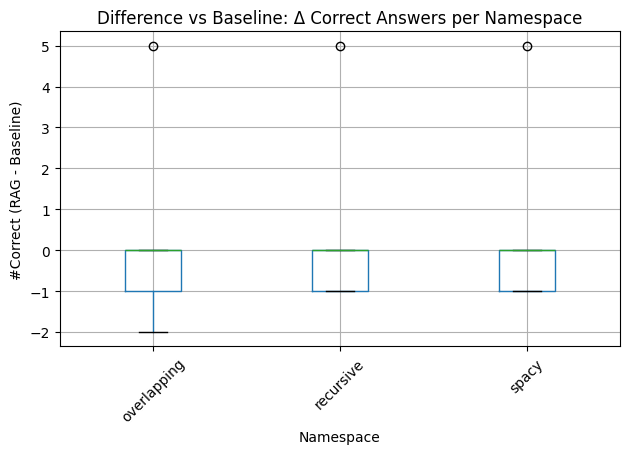

<Figure size 1000x600 with 0 Axes>

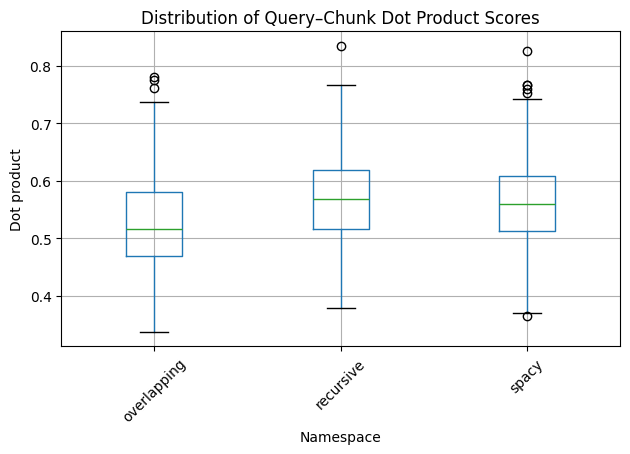

<Figure size 1400x600 with 0 Axes>

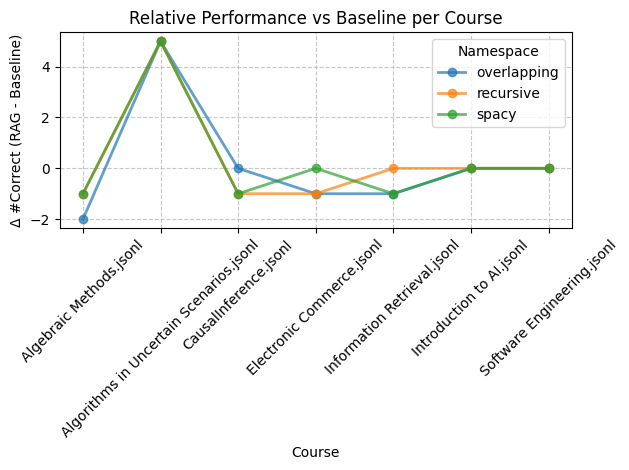


=== Evaluating index: dotproduct-500 ===
Found 3 namespaces: ['overlapping', 'recursive', 'spacy']

🚀 Running evaluation for namespace: overlapping
[run_batch_zip] ZIP path: Q&A.zip
[run_batch_zip] Q&A jsonl files found: 7

===== Processing: Q&A/Q&A/Algebraic Methods.jsonl =====


Questions in Algebraic Methods.jsonl: 100%|██████████| 30/30 [01:03<00:00,  2.10s/it]


Summary for Q&A/Q&A/Algebraic Methods.jsonl: 24/30 correct (80.00%)

===== Processing: Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl =====


Questions in Algorithms in Uncertain Scenarios.jsonl: 100%|██████████| 30/30 [01:06<00:00,  2.21s/it]


Summary for Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/CausalInference.jsonl =====


Questions in CausalInference.jsonl: 100%|██████████| 30/30 [01:53<00:00,  3.80s/it]


Summary for Q&A/Q&A/CausalInference.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Electronic Commerce.jsonl =====


Questions in Electronic Commerce.jsonl: 100%|██████████| 30/30 [01:06<00:00,  2.22s/it]


Summary for Q&A/Q&A/Electronic Commerce.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/Information Retrieval.jsonl =====


Questions in Information Retrieval.jsonl: 100%|██████████| 30/30 [01:55<00:00,  3.86s/it]


Summary for Q&A/Q&A/Information Retrieval.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Introduction to AI.jsonl =====


Questions in Introduction to AI.jsonl: 100%|██████████| 29/29 [01:05<00:00,  2.27s/it]


Summary for Q&A/Q&A/Introduction to AI.jsonl: 27/29 correct (93.10%)

===== Processing: Q&A/Q&A/Software Engineering.jsonl =====


Questions in Software Engineering.jsonl: 100%|██████████| 30/30 [01:39<00:00,  3.33s/it]


Summary for Q&A/Q&A/Software Engineering.jsonl: 30/30 correct (100.00%)

🚀 Running evaluation for namespace: recursive
[run_batch_zip] ZIP path: Q&A.zip
[run_batch_zip] Q&A jsonl files found: 7

===== Processing: Q&A/Q&A/Algebraic Methods.jsonl =====


Questions in Algebraic Methods.jsonl: 100%|██████████| 30/30 [00:18<00:00,  1.59it/s]


Summary for Q&A/Q&A/Algebraic Methods.jsonl: 23/30 correct (76.67%)

===== Processing: Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl =====


Questions in Algorithms in Uncertain Scenarios.jsonl: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it]


Summary for Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/CausalInference.jsonl =====


Questions in CausalInference.jsonl: 100%|██████████| 30/30 [00:10<00:00,  3.00it/s]


Summary for Q&A/Q&A/CausalInference.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Electronic Commerce.jsonl =====


Questions in Electronic Commerce.jsonl: 100%|██████████| 30/30 [00:54<00:00,  1.82s/it]


Summary for Q&A/Q&A/Electronic Commerce.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/Information Retrieval.jsonl =====


Questions in Information Retrieval.jsonl: 100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


Summary for Q&A/Q&A/Information Retrieval.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/Introduction to AI.jsonl =====


Questions in Introduction to AI.jsonl: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Summary for Q&A/Q&A/Introduction to AI.jsonl: 27/29 correct (93.10%)

===== Processing: Q&A/Q&A/Software Engineering.jsonl =====


Questions in Software Engineering.jsonl: 100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


Summary for Q&A/Q&A/Software Engineering.jsonl: 30/30 correct (100.00%)

🚀 Running evaluation for namespace: spacy
[run_batch_zip] ZIP path: Q&A.zip
[run_batch_zip] Q&A jsonl files found: 7

===== Processing: Q&A/Q&A/Algebraic Methods.jsonl =====


Questions in Algebraic Methods.jsonl: 100%|██████████| 30/30 [01:04<00:00,  2.14s/it]


Summary for Q&A/Q&A/Algebraic Methods.jsonl: 22/30 correct (73.33%)

===== Processing: Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl =====


Questions in Algorithms in Uncertain Scenarios.jsonl: 100%|██████████| 30/30 [01:20<00:00,  2.68s/it]


Summary for Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/CausalInference.jsonl =====


Questions in CausalInference.jsonl: 100%|██████████| 30/30 [01:41<00:00,  3.39s/it]


Summary for Q&A/Q&A/CausalInference.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Electronic Commerce.jsonl =====


Questions in Electronic Commerce.jsonl: 100%|██████████| 30/30 [01:03<00:00,  2.13s/it]


Summary for Q&A/Q&A/Electronic Commerce.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/Information Retrieval.jsonl =====


Questions in Information Retrieval.jsonl: 100%|██████████| 30/30 [01:55<00:00,  3.86s/it]


Summary for Q&A/Q&A/Information Retrieval.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Introduction to AI.jsonl =====


Questions in Introduction to AI.jsonl: 100%|██████████| 29/29 [01:06<00:00,  2.28s/it]


Summary for Q&A/Q&A/Introduction to AI.jsonl: 27/29 correct (93.10%)

===== Processing: Q&A/Q&A/Software Engineering.jsonl =====


Questions in Software Engineering.jsonl: 100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


Summary for Q&A/Q&A/Software Engineering.jsonl: 30/30 correct (100.00%)

--- Analysis for index: dotproduct-500 ---

🔍 Debug: Baseline (normalized) map
  algebraic methods -> 24
  algorithms in uncertain scenarios -> 20
  causalinference -> 26
  electronic commerc -> 27
  electronic commerce -> 27
  information retrieval -> 27
  introduction to ai -> 27
  software engineering -> 30

[Namespace=overlapping] Course='Algebraic Methods.jsonl' (norm='algebraic methods')
  Our correct=24, Baseline=24, Δ=0

[Namespace=overlapping] Course='Algorithms in Uncertain Scenarios.jsonl' (norm='algorithms in uncertain scenarios')
  Our correct=26, Baseline=20, Δ=6

[Namespace=overlapping] Course='CausalInference.jsonl' (norm='causalinference')
  Our correct=26, Baseline=26, Δ=0

[Namespace=overlapping] Course='Electronic Commerce.jsonl' (norm='electronic commerce')
  Our correct=27, Baseline=27, Δ=0

[Namespace=overlapping] Course='Information Retrieval.jsonl' (norm='information retrieval')
  Our corr

<Figure size 1000x600 with 0 Axes>

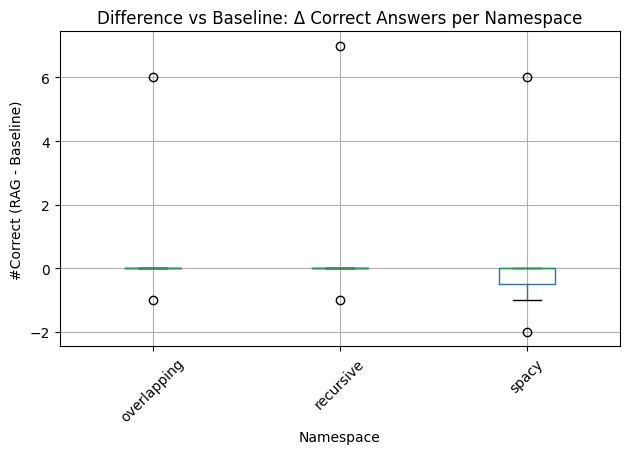

<Figure size 1000x600 with 0 Axes>

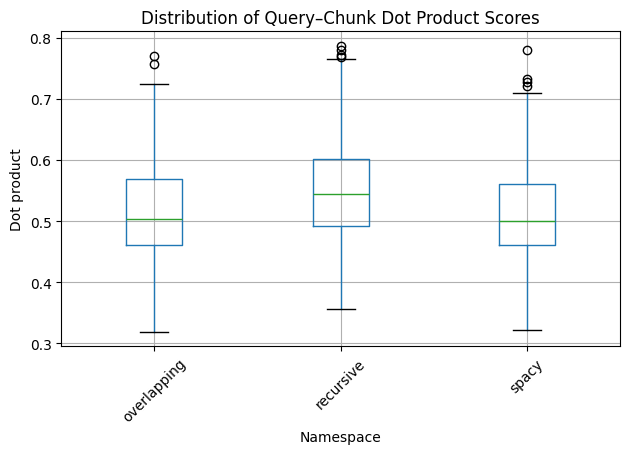

<Figure size 1400x600 with 0 Axes>

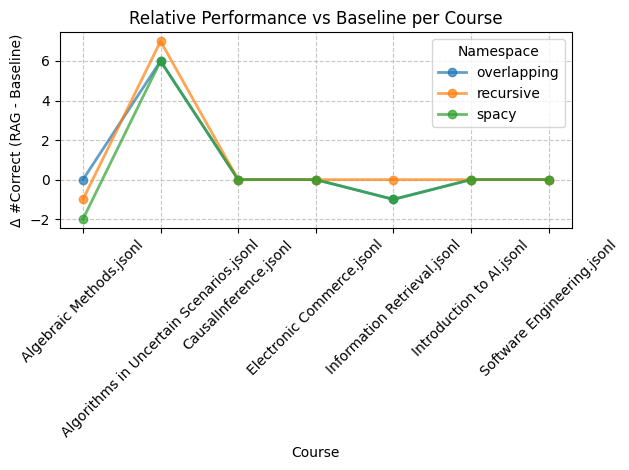


=== Evaluating index: dotproduct-700 ===
Found 3 namespaces: ['overlapping', 'recursive', 'spacy']

🚀 Running evaluation for namespace: overlapping
[run_batch_zip] ZIP path: Q&A.zip
[run_batch_zip] Q&A jsonl files found: 7

===== Processing: Q&A/Q&A/Algebraic Methods.jsonl =====


Questions in Algebraic Methods.jsonl: 100%|██████████| 30/30 [01:54<00:00,  3.82s/it]


Summary for Q&A/Q&A/Algebraic Methods.jsonl: 21/30 correct (70.00%)

===== Processing: Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl =====


Questions in Algorithms in Uncertain Scenarios.jsonl: 100%|██████████| 30/30 [01:58<00:00,  3.96s/it]


Summary for Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/CausalInference.jsonl =====


Questions in CausalInference.jsonl: 100%|██████████| 30/30 [02:01<00:00,  4.05s/it]


Summary for Q&A/Q&A/CausalInference.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Electronic Commerce.jsonl =====


Questions in Electronic Commerce.jsonl: 100%|██████████| 30/30 [01:58<00:00,  3.96s/it]


Summary for Q&A/Q&A/Electronic Commerce.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/Information Retrieval.jsonl =====


Questions in Information Retrieval.jsonl: 100%|██████████| 30/30 [02:05<00:00,  4.20s/it]


Summary for Q&A/Q&A/Information Retrieval.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Introduction to AI.jsonl =====


Questions in Introduction to AI.jsonl: 100%|██████████| 29/29 [02:01<00:00,  4.17s/it]


Summary for Q&A/Q&A/Introduction to AI.jsonl: 27/29 correct (93.10%)

===== Processing: Q&A/Q&A/Software Engineering.jsonl =====


Questions in Software Engineering.jsonl: 100%|██████████| 30/30 [02:01<00:00,  4.04s/it]


Summary for Q&A/Q&A/Software Engineering.jsonl: 30/30 correct (100.00%)

🚀 Running evaluation for namespace: recursive
[run_batch_zip] ZIP path: Q&A.zip
[run_batch_zip] Q&A jsonl files found: 7

===== Processing: Q&A/Q&A/Algebraic Methods.jsonl =====


Questions in Algebraic Methods.jsonl: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]


Summary for Q&A/Q&A/Algebraic Methods.jsonl: 22/30 correct (73.33%)

===== Processing: Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl =====


Questions in Algorithms in Uncertain Scenarios.jsonl: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]


Summary for Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl: 24/30 correct (80.00%)

===== Processing: Q&A/Q&A/CausalInference.jsonl =====


Questions in CausalInference.jsonl: 100%|██████████| 30/30 [00:47<00:00,  1.58s/it]


Summary for Q&A/Q&A/CausalInference.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Electronic Commerce.jsonl =====


Questions in Electronic Commerce.jsonl: 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


Summary for Q&A/Q&A/Electronic Commerce.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/Information Retrieval.jsonl =====


Questions in Information Retrieval.jsonl: 100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


Summary for Q&A/Q&A/Information Retrieval.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/Introduction to AI.jsonl =====


Questions in Introduction to AI.jsonl: 100%|██████████| 29/29 [00:39<00:00,  1.36s/it]


Summary for Q&A/Q&A/Introduction to AI.jsonl: 27/29 correct (93.10%)

===== Processing: Q&A/Q&A/Software Engineering.jsonl =====


Questions in Software Engineering.jsonl: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]


Summary for Q&A/Q&A/Software Engineering.jsonl: 30/30 correct (100.00%)

🚀 Running evaluation for namespace: spacy
[run_batch_zip] ZIP path: Q&A.zip
[run_batch_zip] Q&A jsonl files found: 7

===== Processing: Q&A/Q&A/Algebraic Methods.jsonl =====


Questions in Algebraic Methods.jsonl: 100%|██████████| 30/30 [01:55<00:00,  3.86s/it]


Summary for Q&A/Q&A/Algebraic Methods.jsonl: 24/30 correct (80.00%)

===== Processing: Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl =====


Questions in Algorithms in Uncertain Scenarios.jsonl: 100%|██████████| 30/30 [02:00<00:00,  4.02s/it]


Summary for Q&A/Q&A/Algorithms in Uncertain Scenarios.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/CausalInference.jsonl =====


Questions in CausalInference.jsonl: 100%|██████████| 30/30 [01:57<00:00,  3.92s/it]


Summary for Q&A/Q&A/CausalInference.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Electronic Commerce.jsonl =====


Questions in Electronic Commerce.jsonl: 100%|██████████| 30/30 [02:01<00:00,  4.07s/it]


Summary for Q&A/Q&A/Electronic Commerce.jsonl: 27/30 correct (90.00%)

===== Processing: Q&A/Q&A/Information Retrieval.jsonl =====


Questions in Information Retrieval.jsonl: 100%|██████████| 30/30 [01:54<00:00,  3.81s/it]


Summary for Q&A/Q&A/Information Retrieval.jsonl: 26/30 correct (86.67%)

===== Processing: Q&A/Q&A/Introduction to AI.jsonl =====


Questions in Introduction to AI.jsonl: 100%|██████████| 29/29 [01:58<00:00,  4.07s/it]


Summary for Q&A/Q&A/Introduction to AI.jsonl: 27/29 correct (93.10%)

===== Processing: Q&A/Q&A/Software Engineering.jsonl =====


Questions in Software Engineering.jsonl: 100%|██████████| 30/30 [01:48<00:00,  3.62s/it]


Summary for Q&A/Q&A/Software Engineering.jsonl: 30/30 correct (100.00%)

--- Analysis for index: dotproduct-700 ---

🔍 Debug: Baseline (normalized) map
  algebraic methods -> 24
  algorithms in uncertain scenarios -> 20
  causalinference -> 26
  electronic commerc -> 27
  electronic commerce -> 27
  information retrieval -> 27
  introduction to ai -> 27
  software engineering -> 30

[Namespace=overlapping] Course='Algebraic Methods.jsonl' (norm='algebraic methods')
  Our correct=21, Baseline=24, Δ=-3

[Namespace=overlapping] Course='Algorithms in Uncertain Scenarios.jsonl' (norm='algorithms in uncertain scenarios')
  Our correct=27, Baseline=20, Δ=7

[Namespace=overlapping] Course='CausalInference.jsonl' (norm='causalinference')
  Our correct=26, Baseline=26, Δ=0

[Namespace=overlapping] Course='Electronic Commerce.jsonl' (norm='electronic commerce')
  Our correct=27, Baseline=27, Δ=0

[Namespace=overlapping] Course='Information Retrieval.jsonl' (norm='information retrieval')
  Our cor

<Figure size 1000x600 with 0 Axes>

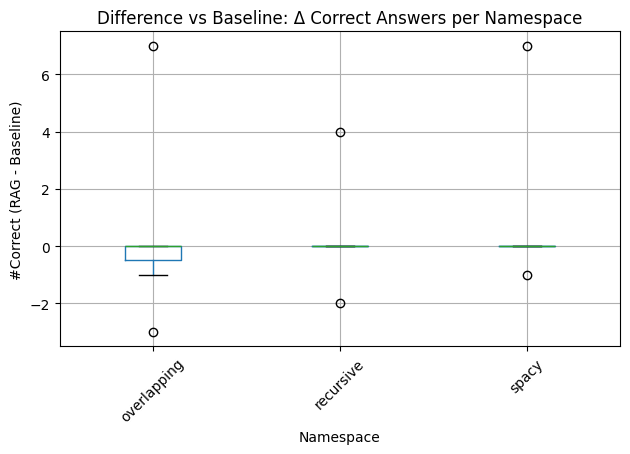

<Figure size 1000x600 with 0 Axes>

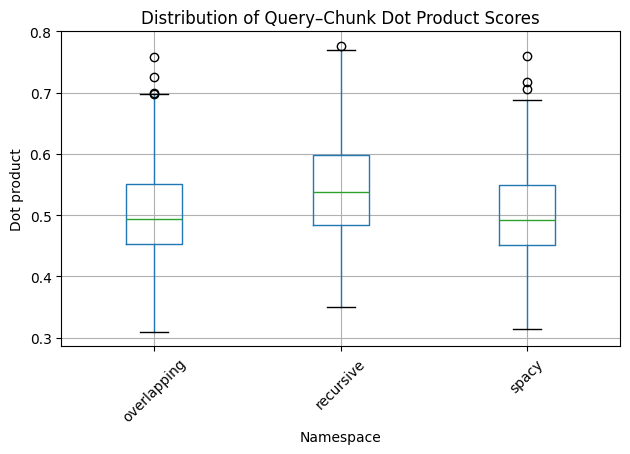

<Figure size 1400x600 with 0 Axes>

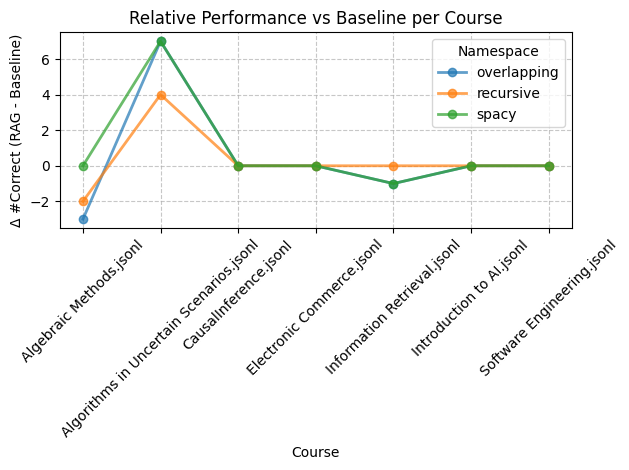

In [119]:
print("🔹 Initializing Pinecone client ...")
pc = Pinecone(api_key=pinecone_api_key)

azure_client = configure_azure_openai(
    endpoint=azure_endpoint,
    api_key=azure_subscription_key,
    api_version=azure_api_version
)
emb_model = load_embedder()

all_results = {}
all_dfs = {}

for index_name in INDICES:
    print(f"\n=== Evaluating index: {index_name} ===")
    namespaces = list_namespaces(pc, index_name)
    print(f"Found {len(namespaces)} namespaces: {namespaces}")
    all_results[index_name] = {}
    for ns in namespaces:
        print(f"\n🚀 Running evaluation for namespace: {ns}")
        ns_results = run_batch_zip(
            pc=pc,
            index_name=index_name,
            namespace=ns,
            emb_model=emb_model,
            azure_client=azure_client,
            azure_deployment=azure_deployment,
            qa_zip_path=qa_zip_path,
            top_k=TOP_K
        )
        all_results[index_name][ns] = ns_results
        time.sleep(5.0)

    # Save per-index results
    with open(f"all_results_{index_name}.json", "w", encoding="utf-8") as f:
        json.dump(all_results[index_name], f, ensure_ascii=False, indent=2)

    # Per-index analysis (returns DataFrames)
    print(f"\n--- Analysis for index: {index_name} ---")
    df_acc, df_sim = analysis_results(all_results[index_name], return_dfs=True)
    all_dfs[index_name] = {"accuracy": df_acc, "similarity": df_sim}
    # save dfs to json
    with open(f"all_dfs_{index_name}.json", "w", encoding="utf-8") as f:
        json.dump({
            "accuracy": df_acc.to_dict(orient="records"),
            "similarity": df_sim.to_dict(orient="records")
        }, f, ensure_ascii=False, indent=2)

# Save all results together
with open("all_results.json", "w", encoding="utf-8") as f:
    json.dump(all_results, f, ensure_ascii=False, indent=2)



<Figure size 1000x600 with 0 Axes>

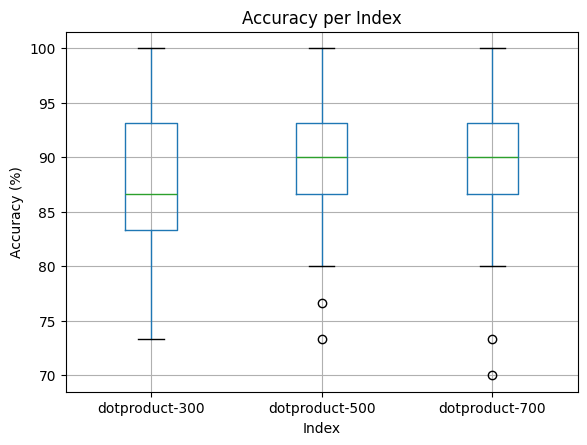

<Figure size 1000x600 with 0 Axes>

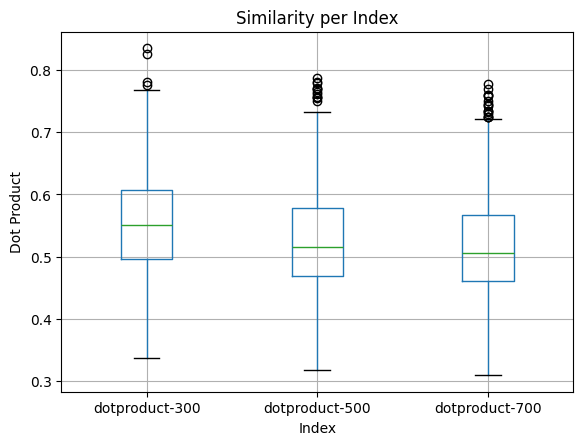

In [120]:
def compare_indices(all_results: dict, indices: list[str]):
    import pandas as pd
    import matplotlib.pyplot as plt

    records_acc = []
    records_sim = []

    for idx in indices:
        idx_data = all_results.get(idx, {})
        for ns, ns_data in idx_data.items():
            for fname, file_data in ns_data.items():
                ours = file_data.get("correct", 0)
                total = file_data.get("total", 0)
                acc = (ours / total * 100.0) if total else 0.0
                records_acc.append({
                    "index": idx,
                    "namespace": ns,
                    "course": fname,
                    "accuracy": acc
                })
                for q in file_data.get("questions", []):
                    for score in (q.get("cosine_scores") or []):
                        records_sim.append({
                            "index": idx,
                            "namespace": ns,
                            "course": fname,
                            "similarity": score
                        })

    df_acc = pd.DataFrame(records_acc)
    df_sim = pd.DataFrame(records_sim)

    plt.figure(figsize=(10,6))
    df_acc.boxplot(column="accuracy", by="index")
    plt.title("Accuracy per Index")
    plt.suptitle("")
    plt.xlabel("Index")
    plt.ylabel("Accuracy (%)")
    plt.show()

    plt.figure(figsize=(10,6))
    df_sim.boxplot(column="similarity", by="index")
    plt.title("Similarity per Index")
    plt.suptitle("")
    plt.xlabel("Index")
    plt.ylabel("Dot Product")
    plt.show()
# Usage:
compare_indices(all_results, ["dotproduct-300", "dotproduct-500", "dotproduct-700"])

<Figure size 1000x600 with 0 Axes>

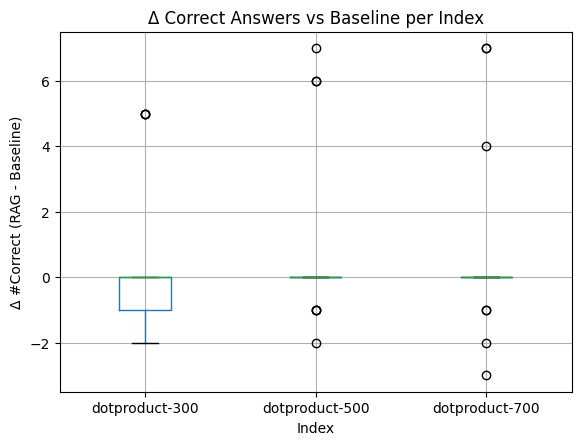

<Figure size 1000x600 with 0 Axes>

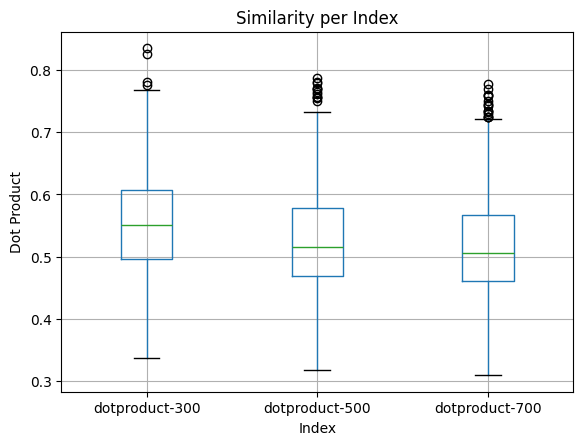

In [121]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# List of index names and corresponding files
indices = ["dotproduct-300", "dotproduct-500", "dotproduct-700"]
dfs_acc = []
dfs_sim = []

for idx in indices:
    with open(f"all_dfs_{idx}.json", "r", encoding="utf-8") as f:
        data = json.load(f)
    df_acc = pd.DataFrame(data["accuracy"])
    df_sim = pd.DataFrame(data["similarity"])
    df_acc["index"] = idx
    df_sim["index"] = idx
    dfs_acc.append(df_acc)
    dfs_sim.append(df_sim)

# Concatenate all indices
df_acc_all = pd.concat(dfs_acc, ignore_index=True)
df_sim_all = pd.concat(dfs_sim, ignore_index=True)

# Example: Boxplot comparison
plt.figure(figsize=(10,6))
df_acc_all.boxplot(column="delta_correct", by="index")
plt.title("Δ Correct Answers vs Baseline per Index")
plt.suptitle("")
plt.xlabel("Index")
plt.ylabel("Δ #Correct (RAG - Baseline)")
plt.show()

plt.figure(figsize=(10,6))
df_sim_all.boxplot(column="similarity", by="index")
plt.title("Similarity per Index")
plt.suptitle("")
plt.xlabel("Index")
plt.ylabel("Dot Product")
plt.show()

In [122]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip



Index: dotproduct-300
  Mann-Whitney U test: U=192728.50, p-value=0.3056
  ➡️ No statistically significant difference in similarity scores between correct and wrong answers.


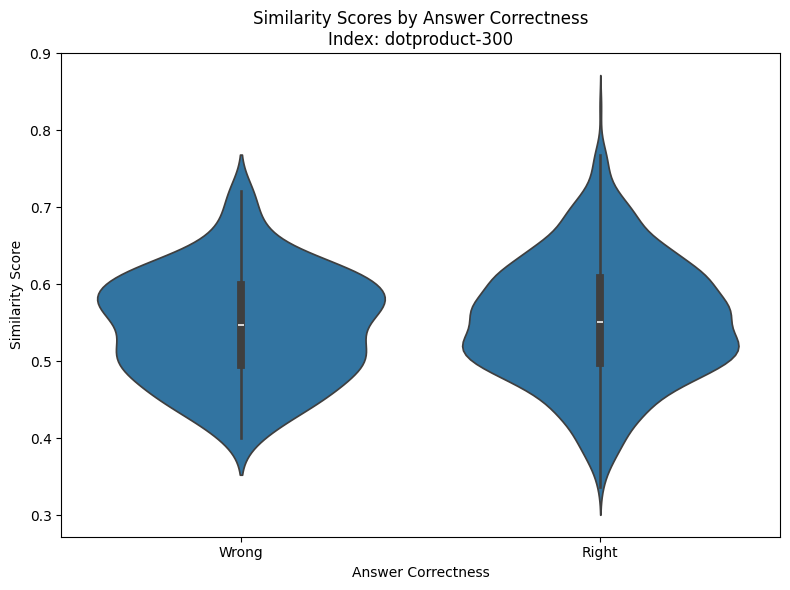


Index: dotproduct-500
  Mann-Whitney U test: U=180269.00, p-value=0.5164
  ➡️ No statistically significant difference in similarity scores between correct and wrong answers.


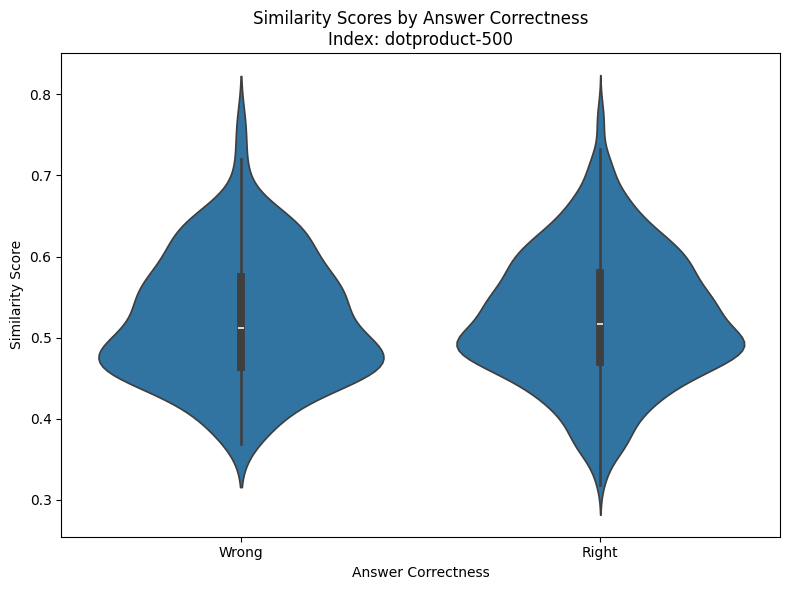


Index: dotproduct-700
  Mann-Whitney U test: U=177320.50, p-value=0.5367
  ➡️ No statistically significant difference in similarity scores between correct and wrong answers.


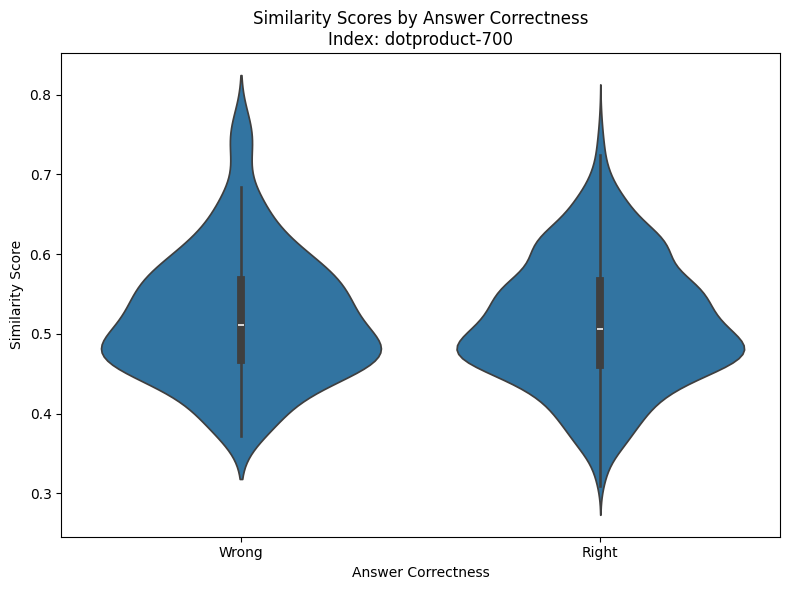

In [123]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

indices = ["dotproduct-300", "dotproduct-500", "dotproduct-700"]

for idx in indices:
    records = []
    with open(f"all_results_{idx}.json", "r", encoding="utf-8") as f:
        all_results = json.load(f)
    for ns, ns_data in all_results.items():
        for course, course_data in ns_data.items():
            for q in course_data.get("questions", []):
                is_correct = int(q.get("gold") == q.get("pred"))
                for score in q.get("cosine_scores", []):
                    records.append({
                        "correct": is_correct,
                        "similarity": score
                    })
    df = pd.DataFrame(records)
    # Statistical test
    sim_right = df[df["correct"] == 1]["similarity"]
    sim_wrong = df[df["correct"] == 0]["similarity"]
    stat, p = mannwhitneyu(sim_right, sim_wrong, alternative="two-sided")
    print(f"\nIndex: {idx}")
    print(f"  Mann-Whitney U test: U={stat:.2f}, p-value={p:.4g}")
    if p < 0.05:
        print("  ➡️ Statistically significant difference in similarity scores between correct and wrong answers.")
    else:
        print("  ➡️ No statistically significant difference in similarity scores between correct and wrong answers.")
    # Plot
    plt.figure(figsize=(8,6))
    sns.violinplot(data=df, x="correct", y="similarity", inner="box")
    plt.xticks([0,1], ["Wrong", "Right"])
    plt.title(f"Similarity Scores by Answer Correctness\nIndex: {idx}")
    plt.xlabel("Answer Correctness")
    plt.ylabel("Similarity Score")
    plt.tight_layout()
    plt.show()

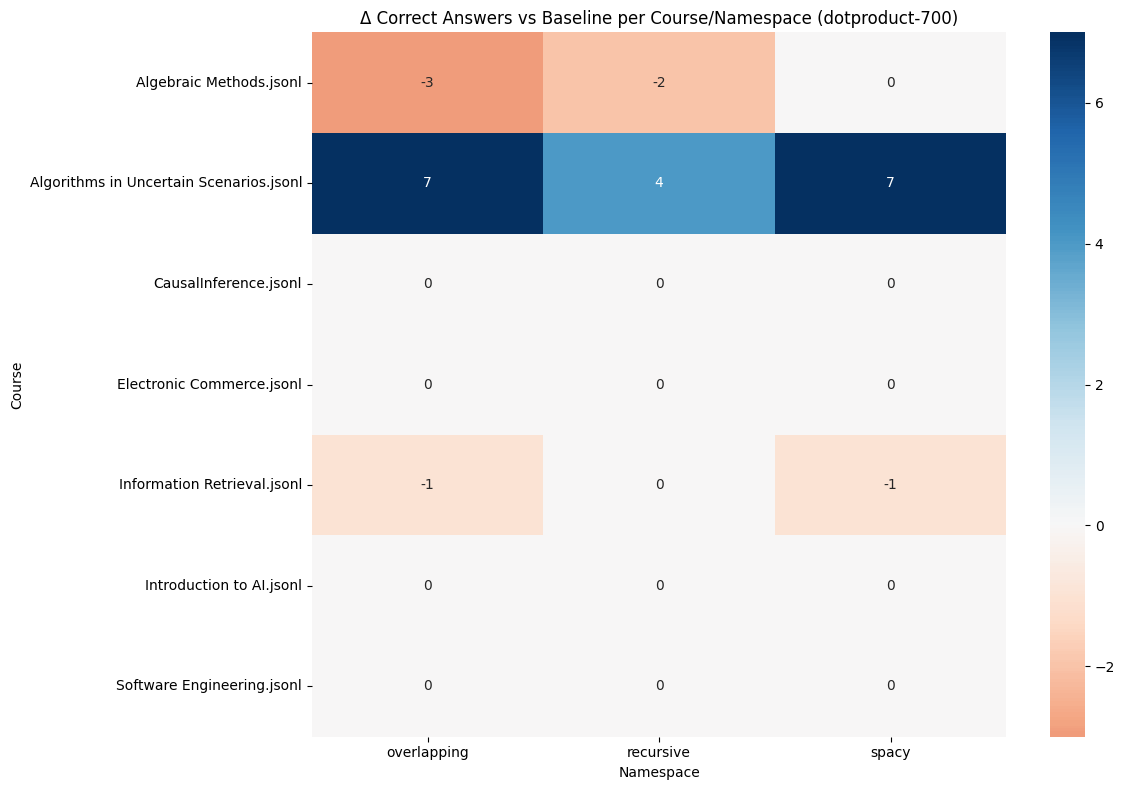

In [124]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

index = "dotproduct-700"  # Change as needed
with open(f"all_dfs_{index}.json", "r", encoding="utf-8") as f:
    data = json.load(f)
df_acc = pd.DataFrame(data["accuracy"])

# Pivot for heatmap: rows=courses, columns=namespaces, values=delta_correct
pivot = df_acc.pivot(index="course", columns="namespace", values="delta_correct")

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="RdBu", center=0)
plt.title(f"Δ Correct Answers vs Baseline per Course/Namespace ({index})")
plt.ylabel("Course")
plt.xlabel("Namespace")
plt.tight_layout()
plt.show()

In [126]:
import json
import pandas as pd
import matplotlib.pyplot as plt

indices = ["dotproduct-300", "dotproduct-500", "dotproduct-700"]
dfs = []

for idx in indices:
    with open(f"all_dfs_{idx}.json", "r", encoding="utf-8") as f:
        data = json.load(f)
    df = pd.DataFrame(data["accuracy"])
    df = df[df["namespace"] == "spacy"].copy()
    df = df[["course", "delta_correct"]]
    df = df.rename(columns={"delta_correct": f"delta_{idx}"})
    dfs.append(df.set_index("course"))

# Merge on course
df_merged = pd.concat(dfs, axis=1).reset_index().sort_values("course")

In [127]:
!pip install tabulate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [129]:
from tabulate import tabulate

indices = ["dotproduct-300", "dotproduct-500", "dotproduct-700"]
all_tables = []

for idx in indices:
    with open(f"all_dfs_{idx}.json", "r", encoding="utf-8") as f:
        data = json.load(f)
    df = pd.DataFrame(data["accuracy"])
    df["index"] = idx
    all_tables.append(df)

df_all = pd.concat(all_tables, ignore_index=True)

summary = (
    df_all.groupby(["index", "namespace"])
    .agg(mean_delta_correct=("delta_correct", "mean"))
    .reset_index()
    .pivot(index="namespace", columns="index", values="mean_delta_correct")
    .round(2)
)

print("Mean Δ Correct Answers vs Baseline (per Namespace, per Index):")
print(tabulate(summary, headers="keys", tablefmt="grid"))

Mean Δ Correct Answers vs Baseline (per Namespace, per Index):
+-------------+------------------+------------------+------------------+
| namespace   |   dotproduct-300 |   dotproduct-500 |   dotproduct-700 |
+=============+==================+==================+==================+
| overlapping |             0.14 |             0.71 |             0.43 |
+-------------+------------------+------------------+------------------+
| recursive   |             0.29 |             0.86 |             0.29 |
+-------------+------------------+------------------+------------------+
| spacy       |             0.29 |             0.43 |             0.86 |
+-------------+------------------+------------------+------------------+
